# Book Recommender Based on kNN with User similarity

On this notebook we will use kNN method for users to build up a recommendation system for an online bookstore.

![kNN method](image/knnimage.png)
(image source: https://commons.wikimedia.org/wiki/File%3AKnnClassification.svg)



Before we start, recall that the recommendation accuracy $\Lambda$ is defined as:
$$\Lambda=\frac{1}{N}\sum_{u=1}^N\frac{|Y_u\cap P_u|}{|Y_u|}$$
where $Y_u$ is the set of books that a user $u$ in the test set purchased, and $P_u$ is the set of books recommended to the user $u$, and $N$ is the total number of users in the test set.


On this notebook there are three different methods, of which we will sketch the algorithm as follows.

##### 1. Based only on the popularity of books

1. Sort all books with respect to the number of transactions of each book.
2. For each user, just recommend the most popular books and calcuate the accuracy $\Lambda$.

##### 2. Based on kNN method (called kNN-only)

Suppose we are given a user $u_0$.

1. We calculate the similarity score between $u_0$ and each other user, say $u_i$, as follows.
$$sim(u_0, u_i) = \frac{|\text{books that both $u_0$ and $u_i$ bought}|}{\sqrt{|\text{books that $u_0$ bought}|\cdot|\text{books that $u_i$ bought}|}}$$
In other words, it is the cosine similarity of "support vectors" of two users, where the support vector of $u_0$, denoted by $v_0$, is the vector of length the same as the number of all books and has value 1 if $u_0$ bought the book on the corresponding position, and 0 elsewhere. Then the similarity score is defined by
$$sim(u_0, u_i) = \frac{v_0\circ v_i}{||v_0||\cdot||v_i||}$$
where $v_i$ is the support vector of $u_i$.
2. We choose $k$ number of users with the largest similarity values (except $u_0$,) denoted by $S(k, u_0)$.
3. From this data we define a score of each book, say $b_j$, as follows.
$$score(b_j) = \sum_{u_i \in S(k, u_0)} \frac{sim(u_0, u_i)\cdot \delta(b_j, u_i)}{\sqrt{|\text{books that $u_i$ bought}|}}$$
$$\delta(b_j, u_i) = 1 \text{ if $u_i$ bought $b_j$ before, } 0 \text{ otherwise}$$
In terms of support vectors, the "score vector of all books" is defined by
$$\overrightarrow{SCORE} = \sum_{u_i \in S(k, u_0)} sim(u_0, u_i)\frac{v_i}{||v_i||}$$
The reason of the normalization factor $||v_i||$ on the denominator is that if some user bought lots of books, we want to regard each book he/she bought less seriously.
4. Excluding books $u_0$ already bought, recommend books with highest scores to $u_0$.
5. Calculate the recommendation accuracy $\Lambda$.

##### 3. Based on kNN method (called weighted kNN)

Suppose we are given a user $u_0$.

1. We define a score of each book by the following.
$$score(b_j) = score_{pop}(b_j) + \alpha\cdot score_{kNN}(b_j, k)$$
Here
$$score_{pop}(b_j) = \frac{|\text{all transactions for $b_j$}|}{|\text{all transactions}|}$$
and $score_{kNN}(b_j, k)$ is the score defined in the second method with given $k$.
2. Excluding books $u_0$ already bought, recommend books with highest scores to $u_0$.
3. Calculate the recommendation accuracy $\Lambda$.

We see that the third method is just the weighted sum of the first two. Meanwhile, on the second method $k$ is a hyperparameter, and on the third on both $k$ and $\alpha$ are hyperparameters. Thus to choose these we perform grid-search on the validation data.

### <center> Grid-Search for kNN-only </center>

![kNN-only grid search](image/konly_grid.jpg)


### <center> Grid-Search for weighted kNN </center>

![weighted kNN grid search](image/knn_grid.jpg)

To run this notebook, one needs to have the data file refined from the other notebook. Also, in order to reduce running time, one needs `sim_dict.pkl`, `sim_dict_w_val.pkl`, `sim_dict_all.pkl`, `all_grid_data.pkl`, `all_grid_konly.pkl`. These files can be found in [the main repository](https://github.com/Clique-CS109/project/tree/master/knn_file).

Now it's time to delve into actual codes.

## 1. Initialization

### 1.1. Import packages

Here we import packages that would be used throughout this notebook. We mainly use `pickle` package to import/export files.

In [1]:
# import basic libraries

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json

Here we are supposed to load Spark libraries to make files used for grid search and verification. But as we will import and use precalculated ones, we just comment this cell.

In [2]:
# import libraries for Spark and initialize it

# import findspark
# findspark.init()
# print findspark.find()
# import pyspark

# conf=pyspark.SparkConf().setAppName('pyspark').setMaster('local[4]').set("spark.executor.memory", "4g")
# sc = pyspark.SparkContext(conf=conf)

### 1.2. Data import and refinement

Here we import data to be used later. All the data are refined from another notebook. In order to use data from each category, just change the file names below. Also, `VAL_NUM` and `TEST_NUM` denote the number of book for each user in the validation data and the test data, respectively. It needs to be changed when we deal with data from each category.

In [3]:
# data import
VAL_NUM=7
TEST_NUM=5

traindf = pd.read_csv("All_train.csv", dtype={'ISBN':np.str, 'ID':np.str, 'Date':np.str, 'Pub_Date':np.str, 'Cart_Date':np.str})
validatedf = pd.read_csv("All_validate.csv", dtype={'ISBN':np.str,'ID':np.str, 'Date':np.str,'Pub_Date':np.str,'Cart_Date':np.str})
testdf = pd.read_csv("All_test.csv", dtype={'ISBN':np.str,'ID':np.str,'Date':np.str,'Pub_Date':np.str,'Cart_Date':np.str})

We make two more dataframes, `tr_va_df` and `alldf`, to be used later.

In [4]:
# tr_va_df is used for testing
tr_va_df =pd.concat([traindf, validatedf])
# alldf is used for the final result
alldf=pd.concat([traindf, validatedf, testdf])

In [5]:
print traindf.shape, validatedf.shape, testdf.shape, tr_va_df.shape, alldf.shape
traindf.head()

(84387, 18) (13874, 18) (9910, 18) (98261, 18) (108171, 18)


,Title,ID,Date,Class,Category,Author,ISBN,Publisher,Pub_Date,Order_Time,Count,Cart,Cart_Date,Device,Address1,Address2,user_purchase_count,book_sell_count
0,데프콘 한미전쟁 세트,168,20141108,주문,국내문학,<김경진> 등저,9788956372389,씨앗을뿌리는사람,20000229.0,20,1,N,NaN,기기PID_PC,인천광역시,계양구,1,1
1,다이버전트,186,20141003,주문,해외문학,<베로니카 로스> 저/<이수현> 역,9788956607108,은행나무,20130807.0,18,1,N,NaN,기기PID_PC,제주특별자치도,서귀포시,1,20
2,"스피라, 세계를 향한 영혼의 승부",188,20140929,주문,자기계발,<김한철> 저,9788925539775,랜덤하우스코리아,20100916.0,19,1,N,NaN,기기PID_PC,인천광역시,강화군,1,2
3,이상한 나라의 앨리스,193,20140910,주문,해외문학,<루이스 캐럴> 저/<김양미> 역/<김민지> 그림,9788992632126,인디고(글담),20071220.0,21,1,N,NaN,기기PID_PC,인천광역시,서구,1,67
4,노인과 바다,217,20140904,주문,해외문학,<어니스트 헤밍웨이> 저/<이종인> 역,9788932911984,열린책들,20120210.0,15,1,N,NaN,기기PID_PC,경기도,수원시 장안구,1,68


Each book has its unique ISBN, thus in order to identify each book it is better to use ISBNs than titles. For example, '오만과 편견' ('Pride and Prejudice') by Jane Austin has several versions with different ISBN, with which we want to deal separately.

In [6]:
print traindf[traindf['Title']=='오만과 편견'].ISBN.unique()

['9788937460883' '9788932911434' '9788998244590' '9788901101811'
 '9788991705135' '9788952764010' '9788901165790' '9788974282974'
 '9788930706391' '9788931006759' '9788932403922' '9791155510032']


However, there is a problem if we use ISBNs. If we look at the data we notice that there are some ISBNs with 2 titles as follows.

In [7]:
title_for_each_ISBN=traindf.groupby('ISBN').Title.unique()
title_for_each_ISBN[title_for_each_ISBN.apply(lambda x: len(x)>1)].head()

ISBN
9788901051598    [그 많던 싱아는 누가 다 먹었을까, [염가한정판매] 그 많던 싱아는 누가 다 먹었을까]
9788901070278                                [다중지능, [염가한정판매] 다중지능]
9788901100920                        [프로이트의 의자, [염가한정판매] 프로이트의 의자]
9788901101569                            [청춘의 독서, [염가한정판매] 청춘의 독서]
9788901106434                [[염가한정판매] 스토리가 스펙을 이긴다, 스토리가 스펙을 이긴다]
Name: Title, dtype: object

It is because there are some titles that start with '[염가한정판매]', which means the book is discounted for limited time. Since it is still the same book, we simply remove '[염가한정판매]' from each title.

In [8]:
# delete [염가한정판매] from title
# Input : dataframe
# Output: same dataframe with [염가한정판매] removed from each title

def del_yeomga(df):
    resdf=df.copy()
    title_series=resdf['Title'].apply(lambda r: r if r[:21]!='[염가한정판매] ' else r[21:])
    resdf['Title']=title_series
    return resdf

traindf   =del_yeomga(traindf)
validatedf=del_yeomga(validatedf)
testdf    =del_yeomga(testdf)
tr_va_df  =del_yeomga(tr_va_df)
alldf     =del_yeomga(alldf)

Now we drop multiple transactions with the same user and ISBN. It means that even if a customer buy the same books several times we consider it as a single transaction. It is because what we want to know is whether a customer likes a book enough to buy it; how many he/she buys the book is not important. By the same reason we will not use `Count` column too.

In [9]:
# drop duplicates - We will NOT use "Count" column
traindf   =traindf.drop_duplicates(['ID','ISBN'])
validatedf=validatedf.drop_duplicates(['ID','ISBN'])
testdf    =testdf.drop_duplicates(['ID','ISBN'])
tr_va_df  =tr_va_df.drop_duplicates(['ID','ISBN'])
alldf     =alldf.drop_duplicates(['ID','ISBN'])

If an ISBN is not given, then we simply drop it.

In [10]:
alldf[pd.isnull(alldf['ISBN'])].shape

(90, 18)

In [11]:
# drop if ISBN is not given
traindf   =traindf[~pd.isnull(traindf['ISBN'])]
validatedf=validatedf[~pd.isnull(validatedf['ISBN'])]
testdf    =testdf[~pd.isnull(testdf['ISBN'])]
tr_va_df  =tr_va_df[~pd.isnull(tr_va_df['ISBN'])]
alldf     =alldf[~pd.isnull(alldf['ISBN'])]

In [12]:
alldf[pd.isnull(alldf['ISBN'])].shape

(0, 18)

Now we extract columns which will be used later. (Actually `Category`, `Author`, `Publisher` columns are not needed for the algorithm, but when we want to show recommended books later they would be useful.)

In [13]:
traindf   =traindf[['Title','ID','Category','Author','ISBN', 'Publisher']]
validatedf=validatedf[['Title','ID','Category','Author','ISBN', 'Publisher']]
testdf    =testdf[['Title','ID','Category','Author','ISBN', 'Publisher']]
tr_va_df  =tr_va_df[['Title','ID','Category','Author','ISBN', 'Publisher']]
alldf     =alldf[['Title','ID','Category','Author','ISBN', 'Publisher']]

In [14]:
traindf.head()

,Title,ID,Category,Author,ISBN,Publisher
0,데프콘 한미전쟁 세트,168,국내문학,<김경진> 등저,9788956372389,씨앗을뿌리는사람
1,다이버전트,186,해외문학,<베로니카 로스> 저/<이수현> 역,9788956607108,은행나무
2,"스피라, 세계를 향한 영혼의 승부",188,자기계발,<김한철> 저,9788925539775,랜덤하우스코리아
3,이상한 나라의 앨리스,193,해외문학,<루이스 캐럴> 저/<김양미> 역/<김민지> 그림,9788992632126,인디고(글담)
4,노인과 바다,217,해외문학,<어니스트 헤밍웨이> 저/<이종인> 역,9788932911984,열린책들


## 2. Preparation Step

### 2.1. Precalculation and its corresponding functions

Here we calculate variables used for grid-search and recommendation. One of the benefits to calculate them in advance is that it reduces time for grid-search, which may take hours or even days.

The following `make_vec` function is to make a support vector where a pair of (sublist, list) is given. For example, if we are given $([a, b, d], [a, b, c, d, e])$ then the result will be $[True, True, False, True, False]$.

In [15]:
# for given items which is a subset of total, return the mask vector corresponding to the positions of items
# Input : items: a list of some books or customers
#         total: a list of all books or customers
# Output: True/False vector with True in the positions corresponding to the given "items"

def make_vec(items,total):
    res=np.zeros(len(total), dtype=bool)
    for i in items:
        res[np.argwhere(total==i)[0][0]]=True
    return res

`compute_support_for_book` makes the dictionary where each key is an ISBN and its value is the vector which corresponds to the buyers of the book with respect to the whole customers. `compute_supports_for_customer` is similar, here each key is a customer and its value is the vector which corresponds to the books he/she bought with respect to the whole books.

In [16]:
# for all books, make a list of vectors of customers who bought each book
# Input : dataframe
# Output: dictionary of the form "ISBN: its support vector with respect to customers who bought it"

def compute_supports_for_book(df):
    IDs=df.ID.unique()
    gb_ISBN = df.groupby('ISBN').ID.unique()
    res={}
    for e,v in zip(gb_ISBN.index.values, gb_ISBN.values):
        res[e] = make_vec(v,IDs)
    return res

# for all customers, make a list of vectors of books that each customer bought
# Input : dataframe
# Output: dictionary of the form "User ID: its support vector with respect to books that they bought"

def compute_supports_for_customer(df):
    ISBNs = df.ISBN.unique()
    gb_ID = df.groupby('ID').ISBN.unique()
    res={}
    for e,v in zip(gb_ID.index.values, gb_ID.values):
        res[e] = make_vec(v,ISBNs)
    return res

Using these functions above, we calculate each dictionary for `traindf`, `tr_va_df`, `alldf`. Usually it takes less than 3 minutes.

In [17]:
# calculate corresponding supports

%time found_supports=compute_supports_for_customer(traindf)
print 'found supports from train dataframe'

%time found_supports_w_val=compute_supports_for_customer(tr_va_df)
print 'found supports from train and validation dataframe'

%time found_supports_all=compute_supports_for_customer(alldf)
print 'found supports from all dataframe'

CPU times: user 45.6 s, sys: 814 ms, total: 46.4 s
Wall time: 49.1 s
found supports from train dataframe
CPU times: user 51.3 s, sys: 353 ms, total: 51.7 s
Wall time: 51.8 s
found supports from train and validation dataframe
CPU times: user 59 s, sys: 367 ms, total: 59.4 s
Wall time: 59.4 s
found supports from all dataframe


This function calculates the proportion of transactions of each book with respect to the whole transactions.

In [18]:
# given dataframe, return a dictionary of proportion of each book among all the books
# Input : dataframe
# Output: dictionary of the form "ISBN: its proportion among all the books"

def get_allbooks_prob(df):
    temp=df.groupby('ISBN').ID.unique().apply(len)
    return dict(temp.apply(lambda r: r*1./temp.sum()))

Using the function above we calculate each dictionary from `traindf`, `tr_va_df`, `alldf`, respectively.

In [19]:
# calculate proportion of each book on the whole data

allbooks_prob=get_allbooks_prob(traindf)
allbooks_prob_w_val=get_allbooks_prob(tr_va_df)
allbooks_prob_all=get_allbooks_prob(alldf)

We also define the dictionary where each user is the key and its value is the set of books he/she bought from each dataframe.

In [20]:
# the set of bought books for each customer

train_bought_set=dict(traindf.groupby('ID').ISBN.unique().apply(set))
validate_bought_set=dict(validatedf.groupby('ID').ISBN.unique().apply(set))
test_bought_set=dict(testdf.groupby('ID').ISBN.unique().apply(set))
tr_va_bought_set=dict(tr_va_df.groupby('ID').ISBN.unique().apply(set))
all_bought_set=dict(alldf.groupby('ID').ISBN.unique().apply(set))

The following function is to calculate similarity for each pair of users. If a dataframe and a user are given, it returns a list of tuples (user u, the similarity value of the given user and user u) sorted by similarity values. Here we use cosine similarity. Note that the data we are dealing with is sparse, i.e. the set of books each user bought is very small compared to the whole books. Thus if we use cosine similarity the computation cost is relatively smaller than other methods, e.g. Pearson correlation. More precisely, the similarity value is defined as follows.


$$sim(u_1, u_2) = \frac{\text{the number of books that $u_1, u_2$ both bought}}{\sqrt{(\text{the number of books that $u_1$ bought})(\text{the number of books that $u_2$ bought})}}$$

If the numerator is zero, then we define it to be zero regardless of whether or not the denominator is also zero.

In [21]:
# given dataframe and userid, return the dictionary of similarity values
# here we used the cosine value as the similarity value
# Input : dataframe and user id
# Output: SORTED list of tuples (User ID of another user, similarity value) if the value is NOT zero

def get_sim(df, cid):
    clist=set(df[df.ID==cid].ISBN.unique())
    res={}
    sup_num=len(clist)
    
    if sup_num==0:
        return []
    
    for i, v in df.groupby('ID').ISBN.unique().iteritems():
        if i != cid:
            int_num=len(clist.intersection(set(v)))
            if int_num !=0:
                res[i]=int_num*1./(np.sqrt(sup_num*len(set(v))))
    
    res_transform = [(j,res[j]) for j in sorted(res, key=res.get, reverse=True)]
    
    return res_transform

Now we are supposed to get the dictionary where keys are user IDs and values are lists of tuples (user u, the similarity value of the given user and user u) as described above. Also we need to get one from each dataframe. However, it takes a lot of time (~30 min for each,) so we will use the precalculated ones stored in files.

###### Note. They can be found in [the main repository](https://github.com/Clique-CS109/project/tree/master/knn_file). Please download files from the corresponding folder. The folders all, domestic, foreign, humanity, religion, self, respectively, denote the data from all categories, Korean (domestic) literature, foreign literature, humanities, religion, self-development, respectively.

Note that when the files were made (see commented cells) we used Spark to reduce processing time.

In [22]:
%%time
# calculate similarity dictionary from train data

with open('sim_dict.pkl', 'rb') as fp:
    sim_dict=pickle.load(fp)

CPU times: user 16 s, sys: 425 ms, total: 16.4 s
Wall time: 16.5 s


In [23]:
# %%time
# sim_dict=dict(sc.parallelize(validatedf.ID.unique(),4).map(lambda r: (r,get_sim(traindf,r))).collect())

In [24]:
# with open('sim_dict.pkl', 'wb') as fp:
#     pickle.dump(sim_dict,fp)

In [25]:
%%time
# calculate similarity dictionary from train and validate data

with open('sim_dict_w_val.pkl', 'rb') as fp:
    sim_dict_w_val=pickle.load(fp)

CPU times: user 32.4 s, sys: 770 ms, total: 33.2 s
Wall time: 33.6 s


In [26]:
# %%time
# sim_dict_w_val=dict(sc.parallelize(testdf.ID.unique(),4).map(lambda r: (r,get_sim(tr_va_df,r))).collect())

In [27]:
# with open('sim_dict_w_val.pkl', 'wb') as fp:
#     pickle.dump(sim_dict_w_val,fp)

In [28]:
%%time
# calculate similarity dictionary from all data

with open('sim_dict_all.pkl', 'rb') as fp:
    sim_dict_all=pickle.load(fp)

CPU times: user 43.6 s, sys: 785 ms, total: 44.4 s
Wall time: 44.7 s


In [29]:
# %%time
# sim_dict_all=dict(sc.parallelize(testdf.ID.unique(),4).map(lambda r: (r,get_sim(alldf,r))).collect())

In [30]:
# with open('sim_dict_all.pkl', 'wb') as fp:
#     pickle.dump(sim_dict_all,fp)

### 2.2. "The main function"

This is the main function for kNN method we use. It takes (dataframe, a list of tuples (user ID, similarity value), a dictionary of support vectors with respect to users, k for kNN method) as the input. Then the result is a dictionary where keys are ISBNs and values are scores of books for each user. The score for given book $b$ and user $u$ is defined as follows.

$$score(b, u) = \sum_{\substack{u'\neq u \\u' \text{ bought } b}} \frac{sim(u, u')}{\sqrt{\text{the number of books that $u'$ bought}}}$$

Its heuristic meaning is that contribution to the score by each user should be proportional to the similarity value but inversely proportional to (the square root of) the number of books he/she bought. For example, if someone bought thousands of books, then each book might not be much valuable to this customer. However, if someone bought only 2 books, then each book would be much more valuable.

In [31]:
# get the result from the dictionary of similarity values
# here weight is defined by "sim_value*support_vector/||support_vector||"; please read the document

# Input : df: dataframe
#         knn_dist: SORTED list of tuples (user ID, sim_value)
#         found_supports: dictionary of the form "User ID: corresponding support vector
#         k: k for k-NN, default=5
# Output: dictionary of the form "ISBN: its corresponding weight for recommendation"


def get_result(df, knn_dist, found_supports, k=5):
    knn=knn_dist[:k]
    res=np.zeros(len(df.ISBN.unique()))
    for (i,j) in knn:
        res+=found_supports[i]*j/np.sqrt(np.sum(found_supports[i]))
    return {k:v for (k,v) in zip(df.ISBN.unique(),res)}

## 3. Grid-search

We will use two different method for recommendation. The first one is to use kNN method (called kNN-only); we defined a score for each user and book, and we recommend books with highest scores. But we need to find the best k, which we will do by grid-search on the validation data.

There is another method; we calculated the proportion of transactions of each book with respect to the whole transactions. It represents the popularity of each book and the most naïve method (except random recommendation...) would be to recommend the most popular books. It is very week *per se*, but what if we mix it with the kNN method? If we add the previous score to the popularity, then wouldn't it be better? For that, we need to choose the weight of the score added to the popularity. For example, if the weight is zero then we depend only on the popularity of each book. On the other hand if the weight is close to $\infty$ then we only use kNN method. For this weight, we will also use grid-search on the validation data.

###### Note: on this notebook we use the symbol p instead of $\alpha$ to denote this weight.

### 3.1. Grid-search function

Here we define grid-search functions for k and weight as described above. Note that if weight is fixed by a sufficiently large number, then it can also be used for grid-search to find k in kNN-only method. 

In [32]:
# grid search for each user
# Input : df: dataframe
#         testset: test set which we wish to predict
#         iter_k: range of k
#         iter_p: range of p
#         found_supports: dictionary of the form "User ID: corresponding support vector
#         allbooks_prob: dictionary of the form "ISBN: its proportion to the whole books"
#         knn_dist: SORTED list of tuples (user ID, sim_value)
#         user_bought: list of books the user already bought
#         all_grid_data: the data we already have from the previous grid search
#         num: the number of books we will recommend to each user
# Output: dictionary of the form "(k,p): the number of books we correctly predicted"
#         If (k,p) was already in all_grid_data, it has the value -1


def do_grid_search(df, testset, iter_k, iter_p, found_supports, allbooks_prob, knn_dist, user_bought, all_grid_data, num):
    numlist={}
    for k in iter_k:
        knnresult=get_result(df, knn_dist, found_supports,k=k)
        for p in iter_p:
            res={book:(allbooks_prob[book]+knnresult[book]*p) for book in df.ISBN.unique() if book not in user_bought}
            numlist[(k,p)]=len(set(sorted(res, key=res.get, reverse=True)[:num]).intersection(testset))
    return numlist

This function is to plot the result of each grid-search.

In [33]:
# plot the result of grid search
# Input : the result of the grid search, range of k, range of p, mode(choose which plot to draw)
# Output: None (it draws the corresponding plot)

def plot_grid_result(plotdata, iter_k, iter_p, mode=False):
    X=np.outer(iter_k,np.ones(len(iter_p),dtype=np.int))
    Y=np.outer(np.ones(len(iter_k)), iter_p) #x,y for 3D plots
    Z=[] # these are for 3D wire plot         
    for k in iter_k:
        Z.append([plotdata[(k,p)] for p in iter_p])
    
    if mode == True:
        ax=Axes3D(plt.figure())
        ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=cm.coolwarm)
        ax.view_init(70, 20) # 3D plot

    ax2=Axes3D(plt.figure())
    ax2.plot_wireframe(X,Y,Z)
    ax2.view_init(20, 70)

### 3.2. Load precalculated data from grid-search

Usually grid-search takes a lot of time; we don't want to throw away results whenever we close this notebook. Thus we will store the result and use this later when we open up this notebook again.

###### Note. They can be found in [the main repository](https://github.com/Clique-CS109/project/tree/master/knn_file). Please download files from the corresponding folder. The folders all, domestic, foreign, humanity, religion, self, respectively, denote the data from all categories, Korean (domestic) literature, foreign literature, humanities, religion, self-development, respectively.

In [34]:
# load grid data from previous search
with open('all_grid_data.pkl', 'rb') as fp:
    all_grid_data=pickle.load(fp)
with open('all_grid_data_konly.pkl', 'rb') as fp:
    all_grid_data_konly=pickle.load(fp)    

How many results do we already have?

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


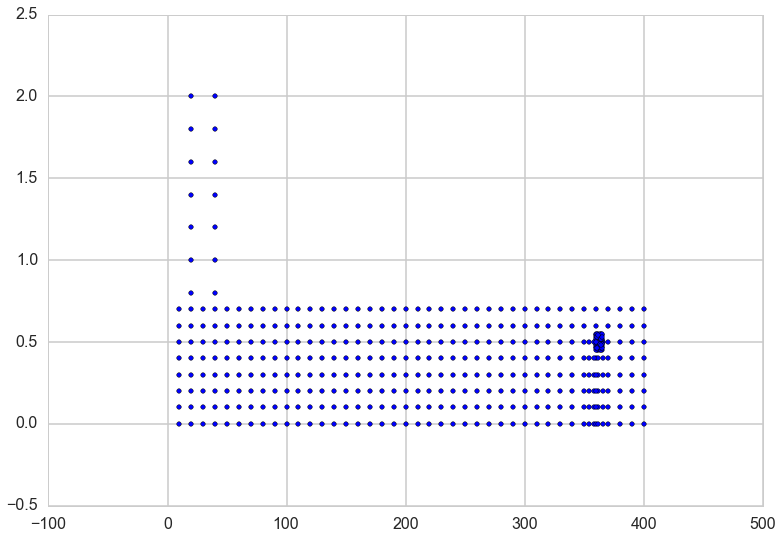

In [35]:
# show which data is in all_grid_data

x,y=zip(*all_grid_data)
plt.scatter(x,y)
plt.show()

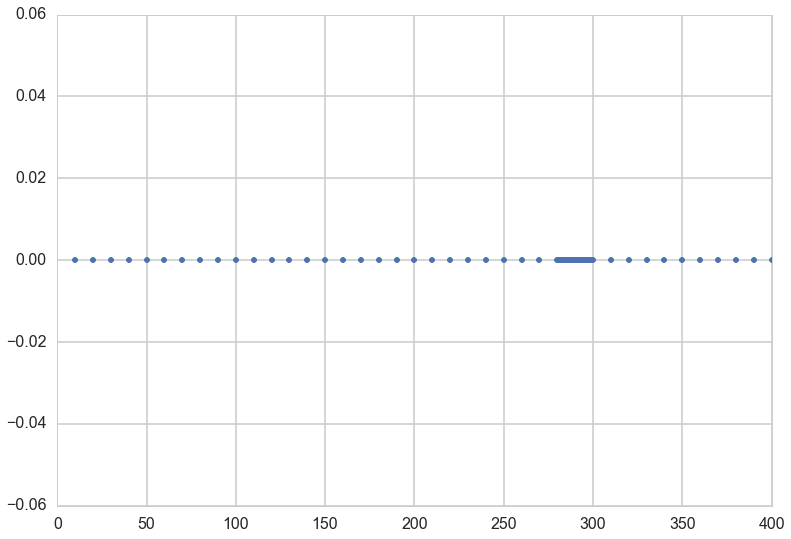

In [36]:
# show which data is in all_grid_data_konly
x=[i for ((i,j),v) in all_grid_data_konly.iteritems()]
y=np.zeros(len(x))
plt.plot(x,y,'.')
plt.show()

### 3.3. Grid-search

We will proceed grid-search for the tuple (k, weight) where the weight is what is multiplied to the score of kNN, which would be added to the popularity of each book. It usually takes a lot of time; calculating for 30 points usually takes ~30 minutes. But if it is already in `all_grid_data`, we will skip grid-search and use this data to plot the result.

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900
MAX: (k,a)=(361, 0.47), num=858
CPU times: user 54.9 ms, sys: 571 µs, total: 55.5 ms
Wall time: 56.3 ms


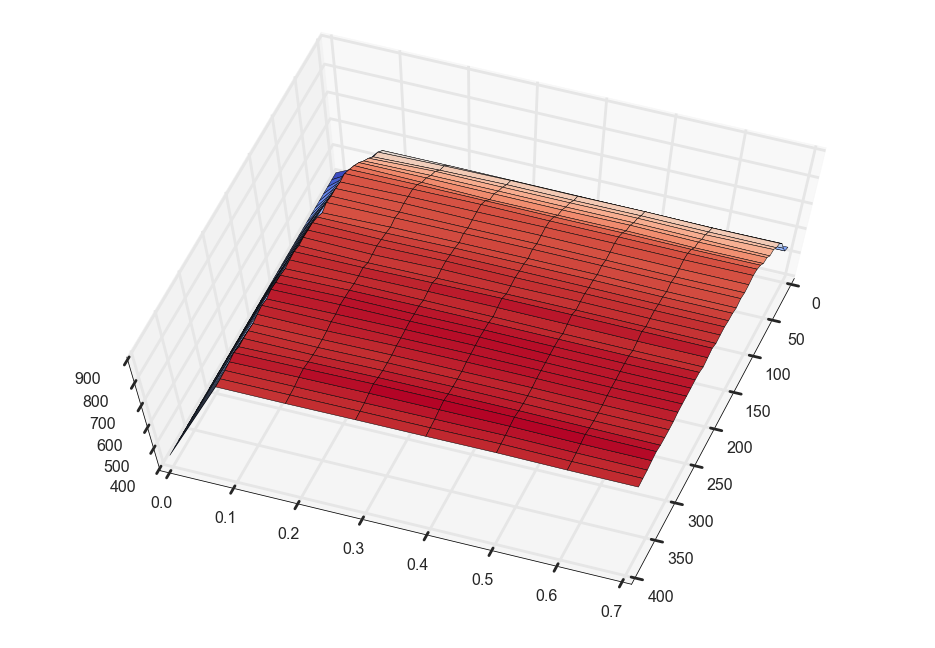

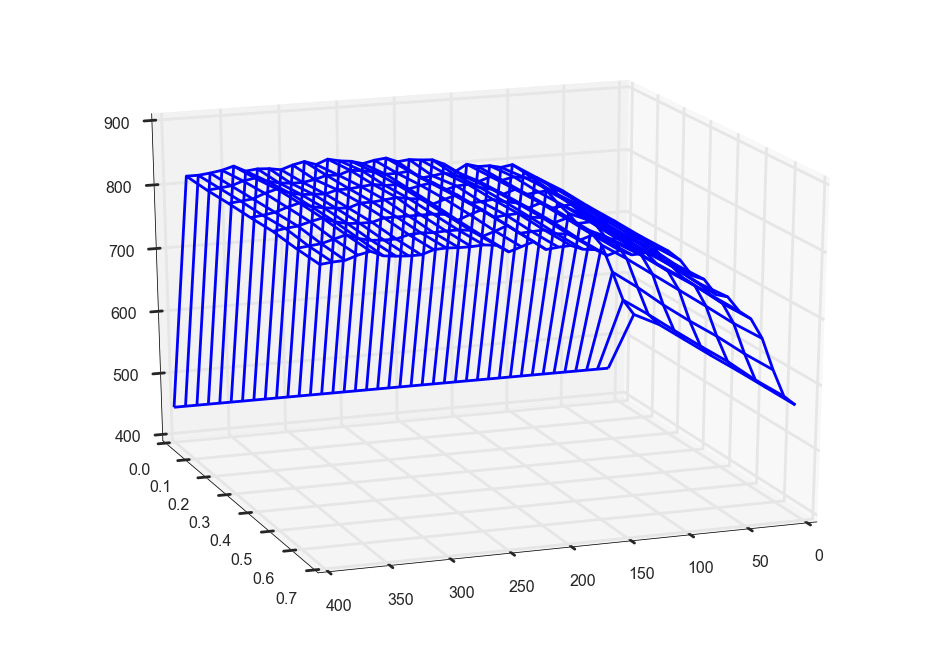

In [37]:
%%time
# grid search for weighted kNN

from collections import defaultdict

if 'all_grid_data' not in globals():
    all_grid_data={}

plotdata=defaultdict(int)
iter_k = np.linspace(10,400,40, dtype=int) # range of k
iter_p = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7] # range of p

iter_k_actual = [k for k in iter_k if not all((k, p) in all_grid_data for p in iter_p)]
# remove points where we already have values

for i,cid in enumerate(validatedf.ID.unique()):
    search_res=do_grid_search(traindf, validate_bought_set[cid], 
                          iter_k_actual, iter_p,
                          found_supports, allbooks_prob,
                          sim_dict[cid], train_bought_set[cid],all_grid_data, VAL_NUM) # grid search
    for k in iter_k_actual:
        for p in iter_p: 
            plotdata[(k,p)] +=search_res[(k,p)]

    if (i+1)%100==0:
        print i+1,     # to check it is working
print 


for k in iter_k:
    for p in iter_p:
        if (k,p) in all_grid_data:
            plotdata[(k,p)]=all_grid_data[(k,p)]
        
for i in plotdata:
    if i not in all_grid_data:
        all_grid_data[i]=plotdata[i]

max_k, max_p = min([(k,v) for k,v in all_grid_data if all_grid_data[(k,v)]==max(all_grid_data.values())])
print 'MAX: (k,a)=%s, num=%s'%((max_k, max_p), all_grid_data[(max_k,max_p)])
plot_grid_result(plotdata,iter_k,iter_p, mode=True)

The following cell is for grid-search to find k for kNN-only method. Here the weight is fixed by $10^9$, which is sufficiently large to be regarded as infinity. This cell is similar to the previous one.

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900
MAX: k=296, num=855
CPU times: user 31 ms, sys: 653 µs, total: 31.7 ms
Wall time: 32.7 ms


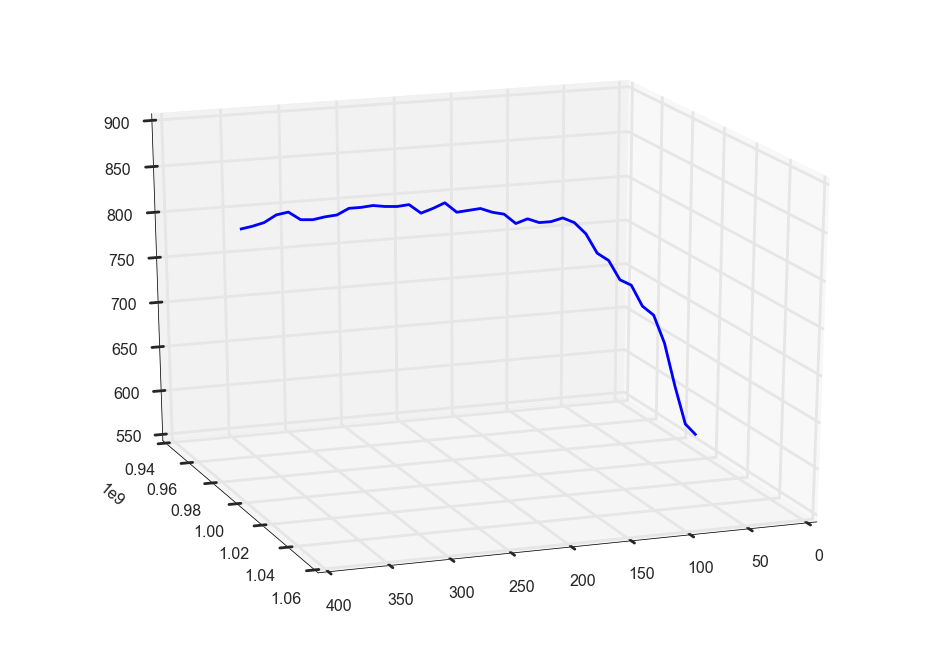

In [38]:
%%time
# grid search for only kNN

from collections import defaultdict

if 'all_grid_data_konly' not in globals():
    all_grid_data_konly={}

plotdata=defaultdict(int)
iter_k = np.linspace(10,400,40, dtype=int) # range of k
iter_p = [1e9] # always fixed

iter_k_actual = [k for k in iter_k if not all((k, p) in all_grid_data_konly for p in iter_p)]
# remove points where we already have values

for i,cid in enumerate(validatedf.ID.unique()):
    search_res=do_grid_search(traindf, validate_bought_set[cid], 
                              iter_k_actual, iter_p,
                              found_supports, allbooks_prob,
                              sim_dict[cid], train_bought_set[cid],all_grid_data_konly, VAL_NUM)   # grid search
    for k in iter_k_actual:
        for p in iter_p: 
            plotdata[(k,p)] +=search_res[(k,p)]
                
    if (i+1)%100==0:
        print i+1, # to check it is working
print

for k in iter_k:
    for p in iter_p:
        if (k,p) in all_grid_data_konly:
            plotdata[(k,p)]=all_grid_data_konly[(k,p)]
        
for i in plotdata:
    if i not in all_grid_data_konly:
        all_grid_data_konly[i]=plotdata[i]

        
max_k_only= min([k for k,v in all_grid_data_konly if all_grid_data_konly[(k,v)]==max(all_grid_data_konly.values())])
print 'MAX: k=%s, num=%s'%(max_k_only, all_grid_data_konly[(max_k_only, 1e9)])        
plot_grid_result(plotdata,iter_k,iter_p)

We store the results obtained from grid-search. Note that if there are several points which attain the maximum accuracy, then we choose the smallest such (k, weight) according to lexicographic order.

In [39]:
max_k, max_p = min([(k,v) for k,v in all_grid_data if all_grid_data[(k,v)]==max(all_grid_data.values())])
max_k_only= min([k for k,v in all_grid_data_konly if all_grid_data_konly[(k,v)]==max(all_grid_data_konly.values())])
total=len(validatedf.ID.unique())*VAL_NUM

This cell shows all the data we obtained by the grid-search for the pair (k, weight). 

MAX: (k,a)=(361, 0.47), prob=6.18422949402%


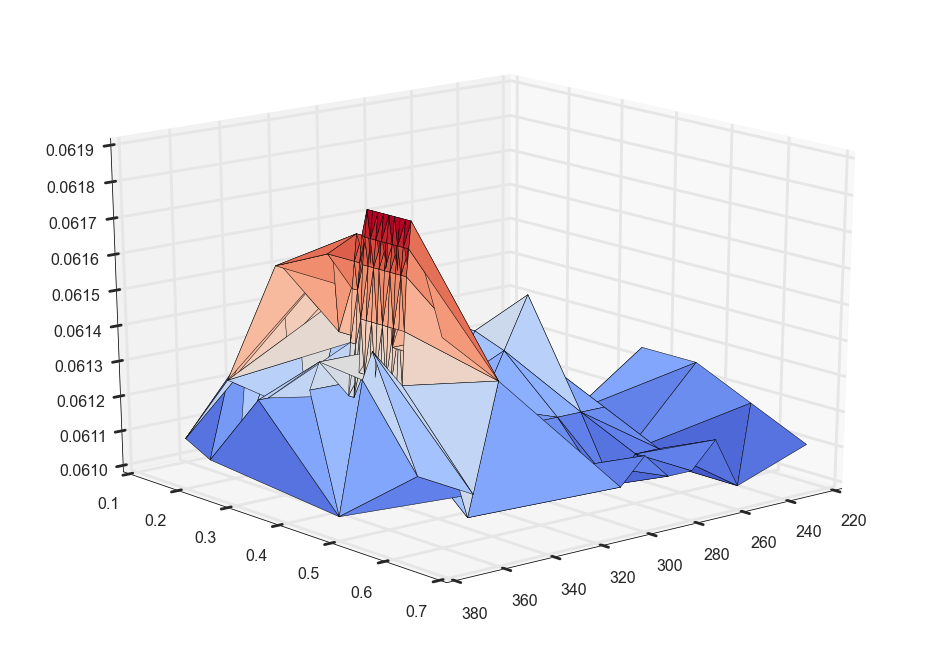

In [40]:
# draw surface plot for all the data in all_grid_data

thres=0.061 # we will plot data whose values are bigger than this threshold

print 'MAX: (k,a)=%s, prob=%s%%'%((max_k, max_p), all_grid_data[(max_k,max_p)]*100./total)
drawdata={k:v*1./total for k,v in all_grid_data.iteritems() if v*1./total>thres}
X,Y=zip(*drawdata)
Z=drawdata.values() # collect data from all_grid_data w.r.t. certain threshold

ax=Axes3D(plt.figure())
ax.plot_trisurf(X,Y,Z, cmap=cm.coolwarm)
ax.view_init(20, 50) # 3D trisurface plot

Likewise, we draw the plot obtained from grid-search for k used in kNN-only method.

MAX: k=296, prob=6.16260631397%


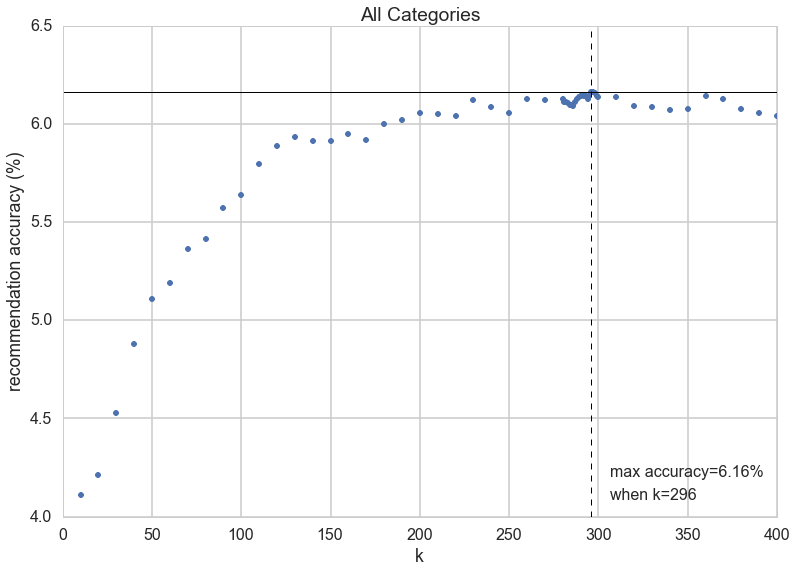

In [41]:
# draw a scatter plot for kNN-only data in all_grid_data_konly

print 'MAX: k=%s, prob=%s%%'%(max_k_only, all_grid_data_konly[(max_k_only, 1e9)]*100./total)
drawdata=[(i,v*100./total) for ((i,j),v) in all_grid_data_konly.iteritems()]
x,y= zip(*drawdata)
#plt.figure(figsize=(7,5))
plt.plot(x,y,'.')
plt.axvline(max_k_only, lw=1, ls='--', color='black')
plt.axhline(all_grid_data_konly[(max_k_only, 1e9)]*100./total, lw=1, color='black')
plt.axvline(max_k_only, lw=0,  label='max accuracy=%.2f%%'%(all_grid_data_konly[(max_k_only, 1e9)]*100./total))
plt.axvline(max_k_only, lw=0,  label='when k=%s'%max_k_only)
plt.xlabel('k')
plt.ylabel('recommendation accuracy (%)')
plt.title("All Categories")
plt.legend(loc=4)
plt.show()

Here comes the interesting part; which one is better? As shown below, we see that if we mix kNN method and naïve popularity method, then it turned out to be *slightly* better than kNN-only method. (It is also true for each category.) But would it be still true if we apply this result to the test data? We will see.

In [42]:
print 'MAX: (k,a)=%s, prob=%s%%'%((max_k, max_p), all_grid_data[(max_k,max_p)]*100./total)
print 'MAX: k=%s, prob=%s%%'%(max_k_only, all_grid_data_konly[(max_k_only, 1e9)]*100./total)

MAX: (k,a)=(361, 0.47), prob=6.18422949402%
MAX: k=296, prob=6.16260631397%


## 4.Test the model!

### 4.1. Which method is the best?

Now we will test the result from grid-search to figure out how accurate our model is as we compare a recommendation list from our method to the actual result. First we define the test function; basically it is similar to `do_grid_search` function, but we input single (k, weight) instead of the range of k and weight.

In [43]:
# test function
# Input : df: dataframe
#         testset: test set which we wish to predict
#         k: the value of k in k-NN
#         p: the value of p
#         found_supports: dictionary of the form "User ID: corresponding support vector
#         allbooks_prob: dictionary of the form "ISBN: its proportion to the whole books"
#         knn_dist: SORTED list of tuples (user ID, sim_value)
#         user_bought: list of books the user already bought
#         num: the number of books that the model recommends
# Output: the number of books we correctly predicted

def get_test_result(df, testset, k, p, found_supports, allbooks_prob, knn_dist, user_bought, num=5):
    knnresult=get_result(df, knn_dist, found_supports,k=k)
    res={book:(allbooks_prob[book]+knnresult[book]*p) for book in df.ISBN.unique() if book not in user_bought}
    return len(set(sorted(res, key=res.get, reverse=True)[:num]).intersection(testset))

Then we test the model on the test data. Here we compare the results from four methods, i.e. naïve popularity, weighted sum of kNN and popularity, kNN-only, and random recommendation.

In [44]:
%%time
# test the model!

pop_res=0
knn_res=0
rand_res=0
knn_only_res=0
allbooks=set(tr_va_df.ISBN.unique())

max_k, max_p = min([(k,v) for k,v in all_grid_data if all_grid_data[(k,v)]==max(all_grid_data.values())])
max_k_only= min([k for k,v in all_grid_data_konly if all_grid_data_konly[(k,v)]==max(all_grid_data_konly.values())])

for i,cid in enumerate(testdf.ID.unique()):
    knn_res+=get_test_result(tr_va_df, test_bought_set[cid], max_k, max_p,
                             found_supports_w_val, allbooks_prob_w_val,
                             sim_dict_w_val[cid], tr_va_bought_set[cid], num=TEST_NUM) # weighted kNN result
    
    knn_only_res+=get_test_result(tr_va_df, test_bought_set[cid], max_k_only, 1e9,
                             found_supports_w_val, allbooks_prob_w_val,
                             sim_dict_w_val[cid], tr_va_bought_set[cid], num=TEST_NUM) # kNN-only result
    
    recom_base={book:allbooks_prob_w_val[book] for book in allbooks if book not in tr_va_bought_set[cid]}
    pop_res+=len(set(sorted(recom_base, key=recom_base.get, reverse=True)[:TEST_NUM]).intersection(test_bought_set[cid]))    
    rand_res+=len(set(np.random.choice(list(allbooks.difference(tr_va_bought_set[cid])), TEST_NUM, replace=False)).intersection(test_bought_set[cid]))
                
    if (i+1)%200==0:
        print i+1,
        
print
print 'popularity  :%s%%'%(pop_res*1./(len(testdf.ID.unique())*TEST_NUM)*100)
print 'weighted kNN:%s%%'%(knn_res*1./(len(testdf.ID.unique())*TEST_NUM)*100)
print 'kNN-only    :%s%%'%(knn_only_res*1./(len(testdf.ID.unique())*TEST_NUM)*100)
print 'random      :%s%%'%(rand_res*1./(len(testdf.ID.unique())*TEST_NUM)*100)

200 400 600 800 1000 1200 1400 1600 1800
popularity  :2.47225025227%
weighted kNN:8.51664984864%
kNN-only    :8.64783047427%
random      :0.0%
CPU times: user 6min 35s, sys: 5.77 s, total: 6min 40s
Wall time: 6min 41s


We see that the kNN-only method is the best among the four. But we observed that if we mix kNN scores and popularity then it gives the better result on the validation data. Why does this happen? It means that we have overfitting problem; compared to kNN-only method, we have 1 more degree of freedon as we mix two methods, so it should give us better result during validation. However, as we apply this result to the test data, it has lower prediction power than using kNN-only method. (This phenomena can be also observed if we look at the data on each category.) Thus we conclude that it is better to use the kNN-only method for recommendation.

### 4.2. How about books? Find similar books if one is given

One advantage of the method we have is that it can be expanded when just the single book is given. If so, then we consider an imaginary user who only bought the given book. Then we have scores for all the other books, so by sorting out the scores we will get the list of similar books to the given one. Note that the function `get_sim_for_book` below is similar to the function `get_sim` defined before.

In [45]:
# For a given book, return a list of users with similarity value
# Input : dataframe, ISBN
# Output: SORTED list of tuples (User ID, similarity value) if the value is NOT zero

def get_sim_for_book(df, isbn):
    res={}
    for i, v in df.groupby('ID').ISBN.unique().iteritems():
        if isbn in v:
            res[i]=1./(np.sqrt(len(set(v))))
    res_transform = [(j,res[j]) for j in sorted(res, key=res.get, reverse=True)]
    return res_transform

Now for a given book, we print out the list of similar books. Here we choose '아프니까 청춘이다', once a famous self-development book in Korea.

In [46]:
# for a given ISBN, return similar books with their similarity values

given_ISBN='9788965700036'
num=20 # the number of books we want to recommend
allbooks=set(alldf.ISBN.unique())

max_k_only= min([k for k,v in all_grid_data_konly if all_grid_data_konly[(k,v)]==max(all_grid_data_konly.values())])

sim=get_sim_for_book(alldf,given_ISBN)

knnresult=get_result(alldf,sim, found_supports_all,k=max_k_only)
recom_knn={book:knnresult[book] for book in allbooks if book !=given_ISBN}

print 'Given book: ISBN %s, "%s"'%(given_ISBN, alldf[alldf['ISBN']==given_ISBN].Title.iloc[0])

res_list=[]
for (n,i) in enumerate(sorted(recom_knn, key=recom_knn.get, reverse=True)[:20]):
    book_data=alldf[alldf['ISBN']==i].iloc[0]
    res_list.append(dict(rank=n+1, ISBN=i, score=recom_knn[i], 
                         title=book_data.Title, author=book_data.Author, publisher=book_data.Publisher))
pd.DataFrame(res_list).set_index('rank')

Given book: ISBN 9788965700036, "아프니까 청춘이다"


,ISBN,author,publisher,score,title
rank,,,,,
1,9788965700609,<혜민 스님> 저/<이영철> 그림,쌤앤파커스,0.566501,"멈추면, 비로소 보이는 것들"
2,9788994013503,<칼 필레머> 저/<박여진> 역,토네이도,0.564460,내가 알고 있는 걸 당신도 알게 된다면
3,9788932916194,<요나스 요나손> 저/<임호경> 역,열린책들,0.541529,창문 넘어 도망친 100세 노인
4,9788933870181,<스튜어트 다이아몬드> 저/<김태훈> 역,8.0(에이트 포인트),0.516883,어떻게 원하는 것을 얻는가
5,9788901150598,<찰스 두히그> 저/<강주헌> 역,갤리온,0.515830,습관의 힘
6,9788984370753,<기욤 뮈소> 저/<윤미연> 역,밝은세상,0.500000,구해줘
7,9791185424156,<박경철> 저,리더스북,0.500000,시골의사 박경철의 청소년을 위한 자기혁명
8,9788954622035,<김영하> 저,문학동네,0.500000,살인자의 기억법
9,9788992378093,<레프 톨스토이> 저/<이상원> 역,조화로운삶,0.473359,살아갈 날들을 위한 공부


### 4.3. Make a list of recommendation for each user

Now we will make a file which contains a list of recommendation for each user. It would be used if we want to apply the kNN-only method we constructed to the real world. Here we will get lists for users only in the test data. The following function will do the job for us, and note that it is very similar to `get_test_result` function.

In [47]:
# for a user in the test set, return a list of recommendation
# Input : df: dataframe
#         k: k for kNN
#         found_supports: dictionary of the form "User ID: corresponding support vector
#         knn_dist: SORTED list of tuples (user ID, sim_value)
#         user_bought: list of books the user already bought
#         num: the number of books that the model recommends
# Output: a SORTED list of num-ISBNs with highest probabilities

def get_final_output(df, k, found_supports, knn_dist, user_bought, num=5):
    knnresult=get_result(df, knn_dist, found_supports,k=k)
    res={book:knnresult[book] for book in df.ISBN.unique() if book not in user_bought}
    return sorted(res, key=res.get, reverse=True)[:num]

Here we make a dictionary where keys are ISBNs and values are titles. It takes 3~4 minutes.

In [48]:
# make a dictionary of the form "ISBN: title"
%time titlelist={isbn:alldf[alldf['ISBN']==isbn].Title.iloc[0] for isbn in alldf.ISBN.unique()}

CPU times: user 3min 12s, sys: 498 ms, total: 3min 12s
Wall time: 3min 12s


Now we produce the final output...

In [49]:
# making a list of recommended books for each user - will be used to do the actual test

num=20 # the number of books which would be contained in a recommendation list for each user
max_k_only= min([k for k,v in all_grid_data_konly if all_grid_data_konly[(k,v)]==max(all_grid_data_konly.values())])

final_output={}

for cid in testdf.ID.unique():
    final_output[cid]= {pr+1:{'ISBN': isbn, 'title':titlelist[isbn]} for pr,isbn in enumerate(get_final_output(alldf, max_k_only, found_supports_all ,sim_dict_all[cid], all_bought_set[cid], num=num))}

and export it to a JSON file.

In [50]:
with open("test_output.json", "w") as fd:
    json.dump(final_output, fd)

This file can be found in [the main repository](https://github.com/Clique-CS109/project/tree/master/knn_file).

## 5. Save and quit

Before we close this notebook, don't forget to export grid-search data to files. (They are expensive!)

In [51]:
# save the grid search data

with open('all_grid_data.pkl', 'wb') as fp:
    pickle.dump(all_grid_data,fp)

with open('all_grid_data_konly.pkl', 'wb') as fp:
    pickle.dump(all_grid_data_konly,fp)

We're done!